In [46]:
import torch
import os
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
import matplotlib.pyplot as plt
import glob
import re
import csv
from tifffile import imwrite
import numpy as np
from PIL import Image
import fnmatch
import shutil
from my_utils_v2 import Utils_v2
from AF_Removal_Set02 import AF_Removal_Set_02
from tqdm import tqdm
import subprocess
from collections import defaultdict
import gc

***Load all the images***

In [47]:
tissue_path='/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set02/GCA022ACB/Registered'
tissue_name='GCA022ACB_TISSUE03'
mask_path=f'/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set02/GCA022ACB/Registered/{tissue_name}_RetentionMask.tif'
output_path='/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2'

In [48]:
mask_path

'/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set02/GCA022ACB/Registered/GCA022ACB_TISSUE03_RetentionMask.tif'

In [49]:
all_tissues=[]
for file in os.listdir(tissue_path):
    if fnmatch.fnmatch(file, f'{tissue_name}_*'):
        all_tissues.append(os.path.join(tissue_path, file))
print(len(all_tissues))

78


In [50]:
filtered_tissues = list(filter(lambda x: 'RetentionMask' not in x, all_tissues))
print(len(filtered_tissues))
# Group the strings by round number
tissues_by_round = defaultdict(list)
for tissue in filtered_tissues:
    round_number = int(re.search('ROUND_(\\d+)', tissue).group(1))
    tissues_by_round[round_number].append(tissue)

# Sort the dictionary items by key (round number)
sorted_items = sorted(tissues_by_round.items())

# Sort each group so that the string containing "DAPI_DAPI" comes first, and convert the sorted dictionary items to a list
grouped_tissues = [sorted(group, key=lambda x: f'{tissue_name}_DAPI' not in x) for _, group in sorted_items]

77


In [51]:
grouped_tissues

[['/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set02/GCA022ACB/Registered/GCA022ACB_TISSUE03_DAPI_DAPI_12ms_ROUND_00.tif',
  '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set02/GCA022ACB/Registered/GCA022ACB_TISSUE03_WGA_CY5_75ms_ROUND_00.tif',
  '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set02/GCA022ACB/Registered/GCA022ACB_TISSUE03_AF_CY2_75ms_ROUND_00.tif',
  '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set02/GCA022ACB/Registered/GCA022ACB_TISSUE03_SNA_CY3_50ms_ROUND_00.tif'],
 ['/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set02/GCA022ACB/Registered/GCA022ACB_TISSUE03_DAPI_DAPI_12ms_ROUND_01.tif',
  '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set02/GCA022ACB/Registered/GCA022ACB_TISSUE03_Background_CY2_75ms_ROUND_01.tif',
  '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set02/GCA022ACB/Registered/GCA022ACB_TISSUE03_Background_CY2_0ms_ROUND_01.tif',
  '/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set02/GCA022ACB/Registered/GCA022ACB_TISS

In [52]:
round0_dapi = grouped_tissues[0][0]
round0_dapi,height,width = Utils_v2.load_tissues_for_overlap(round0_dapi,mask_path)

***Generate the Deformation Mask***

In [26]:
round0_dapi_for_composition = grouped_tissues[0][0]
round_last_dapi_for_compositin = grouped_tissues[-1][0]
block_size = 1024

round0_dapi_for_composition=np.array(Image.open(round0_dapi_for_composition)) / 255.
round_last_dapi_for_compositin=np.array(Image.open(round_last_dapi_for_compositin)) /255.
original_height, original_width = round0_dapi_for_composition.shape

pad_size0 = block_size - round0_dapi_for_composition.shape[0] % block_size
pad_size1 = block_size - round0_dapi_for_composition.shape[1] % block_size

# Pad the images
round0_dapi_for_composition = np.pad(round0_dapi_for_composition, ((0, pad_size0), (0, pad_size1)))
round_last_dapi_for_compositin = np.pad(round_last_dapi_for_compositin, ((0, pad_size0), (0, pad_size1)))

In [27]:
model_path='/home-local/rudravg/test_DAPI/1024_Dataset_V2/Smoothness_1_epochs/epoch_15/epoch_15.pth'
model,device=Utils_v2.load_model(model_path) #Write this code

/home/local/VANDERBILT/rudravg/miniconda3/envs/dapi_reg/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [28]:
L2_norm=Utils_v2.L2_norm_mask(round0_dapi_for_composition,round_last_dapi_for_compositin,model,device)

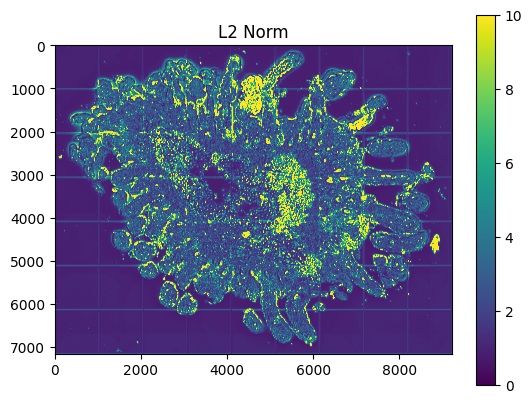

In [29]:
plt.figure()

# Display the L2 norm
plt.imshow(L2_norm, cmap='viridis',vmin=0,vmax=10)

# Add a colorbar
plt.colorbar()

# Set the title
plt.title('L2 Norm')
# Show the plot
plt.show()

In [30]:
mask = L2_norm > 10

mask_image = (mask * 255).astype(np.uint8)
mask_image = mask_image[:original_height, :original_width]

***Perform Registration and save images***

In [31]:
height1,width1=round0_dapi.shape
pad_height=height1-mask_image.shape[0]
pad_width=width1-mask_image.shape[1]

mask_image=np.pad(mask_image,((0,pad_height),(0,pad_width)))
round0_dapi[mask_image == 255] = 0


In [32]:
new_dir = os.path.join(output_path, tissue_name)

In [33]:
print(new_dir)

/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01


In [34]:
#Save Round 0 Images
os.makedirs(new_dir, exist_ok=True)

for file_path in grouped_tissues[0]:
    file,height,width=Utils_v2.load_tissues_for_overlap(file_path,mask_path)
    file=file*255.
    file = file[:height, :width]
    Image.fromarray(np.uint8(file)).save(os.path.join(new_dir, os.path.basename(file_path)))

In [35]:
i=0
for group in grouped_tissues[1:]:
    stains=len(group)
    i+=1
    print(f"Registering Round {i}, which has {stains} number of stains")
    if stains==1:
        print("Bruh where are all the tissues")
    elif stains==2:
        roundi_dapi = group[0]
        stain1=group[1]
        roundi_dapi,_,_ = Utils_v2.load_tissues_for_overlap(roundi_dapi,mask_path)
        stain1,_,_ = Utils_v2.load_tissues_for_overlap(stain1,mask_path)
        roundi_dapi[mask_image == 255] = 0
        stain1[mask_image == 255] = 0
        registered_dapi,registered_stain1=Utils_v2.register_multiple_tissues_with_overlap(dapi_round_last=roundi_dapi,dapi_round0=round0_dapi,
                                                                                          stain1=stain1,model=model,device=device)
        registered_dapi = registered_dapi*255.
        registered_stain1 = registered_stain1*255.
        registered_dapi = registered_dapi[:height, :width]
        registered_stain1 = registered_stain1[:height, :width]
        Image.fromarray(registered_dapi).save(os.path.join(new_dir,os.path.basename(group[0])))
        Image.fromarray(registered_stain1).save(os.path.join(new_dir,os.path.basename(group[1])))
    elif stains==3:
        roundi_dapi = group[0]
        stain1=group[1]
        stain2=group[2]
        roundi_dapi,_,_ = Utils_v2.load_tissues_for_overlap(roundi_dapi,mask_path)
        stain1,_,_ = Utils_v2.load_tissues_for_overlap(stain1,mask_path)
        stain2,_,_ = Utils_v2.load_tissues_for_overlap(stain2,mask_path)
        roundi_dapi[mask_image == 255] = 0
        stain1[mask_image == 255] = 0
        stain2[mask_image == 255] = 0
        registered_dapi,registered_stain1,registered_stain2=Utils_v2.register_multiple_tissues_with_overlap(dapi_round_last=roundi_dapi,dapi_round0=round0_dapi,
                                                                                          stain1=stain1,stain2=stain2,model=model,device=device)
        registered_dapi = registered_dapi*255.
        registered_stain1 = registered_stain1*255.
        registered_stain2 = registered_stain2*255.
        registered_dapi = registered_dapi[:height, :width]
        registered_stain1 = registered_stain1[:height, :width]
        registered_stain2 = registered_stain2[:height, :width]
    
        Image.fromarray(registered_dapi).save(os.path.join(new_dir,os.path.basename(group[0])))
        Image.fromarray(registered_stain1).save(os.path.join(new_dir,os.path.basename(group[1])))
        Image.fromarray(registered_stain2).save(os.path.join(new_dir,os.path.basename(group[2])))
    elif stains==4:
        roundi_dapi = group[0]
        stain1=group[1]
        stain2=group[2]
        stain3=group[3]
        roundi_dapi,_,_ = Utils_v2.load_tissues_for_overlap(roundi_dapi,mask_path)
        stain1,_,_ = Utils_v2.load_tissues_for_overlap(stain1,mask_path)
        stain2,_,_ = Utils_v2.load_tissues_for_overlap(stain2,mask_path)
        stain3,_,_ = Utils_v2.load_tissues_for_overlap(stain3,mask_path)
        roundi_dapi[mask_image == 255] = 0
        stain1[mask_image == 255] = 0
        stain2[mask_image == 255] = 0
        stain3[mask_image == 255] = 0
        registered_dapi,registered_stain1,registered_stain2,registered_stain3=Utils_v2.register_multiple_tissues_with_overlap(dapi_round_last=roundi_dapi,dapi_round0=round0_dapi,
                                                                                          stain1=stain1,stain2=stain2,stain3=stain3,model=model,device=device)
        registered_dapi = registered_dapi*255.
        registered_stain1 = registered_stain1*255.
        registered_stain2 = registered_stain2*255.
        registered_stain3 = registered_stain3*255.
        registered_dapi = registered_dapi[:height, :width]
        registered_stain1 = registered_stain1[:height, :width]
        registered_stain2 = registered_stain2[:height, :width]
        registered_stain3 = registered_stain3[:height, :width]
        Image.fromarray(np.uint8(registered_dapi)).save(os.path.join(new_dir,os.path.basename(group[0])))
        Image.fromarray(np.uint8(registered_stain1)).save(os.path.join(new_dir,os.path.basename(group[1])))
        Image.fromarray(np.uint8(registered_stain2)).save(os.path.join(new_dir,os.path.basename(group[2])))
        Image.fromarray(np.uint8(registered_stain3)).save(os.path.join(new_dir,os.path.basename(group[3])))
    elif stains==5:
        roundi_dapi = group[0]
        stain1=group[1]
        stain2=group[2]
        stain3=group[3]
        stain4=group[4]
        roundi_dapi,_,_ = Utils_v2.load_tissues_for_overlap(roundi_dapi,mask_path)
        stain1,_,_ = Utils_v2.load_tissues_for_overlap(stain1,mask_path)
        stain2,_,_ = Utils_v2.load_tissues_for_overlap(stain2,mask_path)
        stain3,_,_ = Utils_v2.load_tissues_for_overlap(stain3,mask_path)
        stain4,_,_ = Utils_v2.load_tissues_for_overlap(stain4,mask_path)
        roundi_dapi[mask_image == 255] = 0
        stain1[mask_image == 255] = 0
        stain2[mask_image == 255] = 0
        stain3[mask_image == 255] = 0
        stain4[mask_image == 255] = 0
        registered_dapi,registered_stain1,registered_stain2,registered_stain3,registered_stain4=Utils_v2.register_multiple_tissues_with_overlap(dapi_round_last=roundi_dapi,dapi_round0=round0_dapi,
                                                                                          stain1=stain1,stain2=stain2,stain3=stain3,stain4=stain4,model=model,device=device)
        registered_dapi = registered_dapi*255.
        registered_stain1 = registered_stain1*255.
        registered_stain2 = registered_stain2*255.
        registered_stain3 = registered_stain3*255.
        registered_stain4 = registered_stain4*255.
        registered_dapi = registered_dapi[:height, :width]
        registered_stain1 = registered_stain1[:height, :width]
        registered_stain2 = registered_stain2[:height, :width]
        registered_stain3 = registered_stain3[:height, :width]
        registered_stain4 = registered_stain4[:height, :width]
        Image.fromarray(np.uint8(registered_dapi)).save(os.path.join(new_dir,os.path.basename(group[0])))
        Image.fromarray(np.uint8(registered_stain1)).save(os.path.join(new_dir,os.path.basename(group[1])))
        Image.fromarray(np.uint8(registered_stain2)).save(os.path.join(new_dir,os.path.basename(group[2])))
        Image.fromarray(np.uint8(registered_stain3)).save(os.path.join(new_dir,os.path.basename(group[3])))
        Image.fromarray(np.uint8(registered_stain4)).save(os.path.join(new_dir,os.path.basename(group[4])))
    elif stains==6:
        roundi_dapi = group[0]
        stain1=group[1]
        stain2=group[2]
        stain3=group[3]
        stain4=group[4]
        stain5=group[5]
        roundi_dapi,_,_ = Utils_v2.load_tissues_for_overlap(roundi_dapi,mask_path)
        stain1,_,_ = Utils_v2.load_tissues_for_overlap(stain1,mask_path)
        stain2,_,_ = Utils_v2.load_tissues_for_overlap(stain2,mask_path)
        stain3,_,_ = Utils_v2.load_tissues_for_overlap(stain3,mask_path)
        stain4,_,_ = Utils_v2.load_tissues_for_overlap(stain4,mask_path)
        stain5,_,_ = Utils_v2.load_tissues_for_overlap(stain5,mask_path)
        roundi_dapi[mask_image == 255] = 0
        stain1[mask_image == 255] = 0
        stain2[mask_image == 255] = 0
        stain3[mask_image == 255] = 0
        stain4[mask_image == 255] = 0
        stain5[mask_image == 255] = 0
        registered_dapi,registered_stain1,registered_stain2,registered_stain3,registered_stain4,registered_stain5=Utils_v2.register_multiple_tissues_with_overlap(dapi_round_last=roundi_dapi,dapi_round0=round0_dapi,
                                                                                          stain1=stain1,stain2=stain2,stain3=stain3,stain4=stain4,stain5=stain5,model=model,device=device)
        registered_dapi = registered_dapi*255.
        registered_stain1 = registered_stain1*255.
        registered_stain2 = registered_stain2*255.
        registered_stain3 = registered_stain3*255.
        registered_stain4 = registered_stain4*255.
        registered_stain5 = registered_stain5*255.
        registered_dapi = registered_dapi[:height, :width]
        registered_stain1 = registered_stain1[:height, :width]
        registered_stain2 = registered_stain2[:height, :width]
        registered_stain3 = registered_stain3[:height, :width]
        registered_stain4 = registered_stain4[:height, :width]
        registered_stain5 = registered_stain5[:height, :width]
        Image.fromarray(np.uint8(registered_dapi)).save(os.path.join(new_dir,os.path.basename(group[0])))
        Image.fromarray(np.uint8(registered_stain1)).save(os.path.join(new_dir,os.path.basename(group[1])))
        Image.fromarray(np.uint8(registered_stain2)).save(os.path.join(new_dir,os.path.basename(group[2])))
        Image.fromarray(np.uint8(registered_stain3)).save(os.path.join(new_dir,os.path.basename(group[3])))
        Image.fromarray(np.uint8(registered_stain4)).save(os.path.join(new_dir,os.path.basename(group[4])))
        Image.fromarray(np.uint8(registered_stain5)).save(os.path.join(new_dir,os.path.basename(group[5])))
    elif stains==7:
        roundi_dapi = group[0]
        stain1=group[1]
        stain2=group[2]
        stain3=group[3]
        stain4=group[4]
        stain5=group[5]
        stain6=group[6]
        roundi_dapi,_,_ = Utils_v2.load_tissues_for_overlap(roundi_dapi,mask_path)
        stain1,_,_ = Utils_v2.load_tissues_for_overlap(stain1,mask_path)
        stain2,_,_ = Utils_v2.load_tissues_for_overlap(stain2,mask_path)
        stain3,_,_ = Utils_v2.load_tissues_for_overlap(stain3,mask_path)
        stain4,_,_ = Utils_v2.load_tissues_for_overlap(stain4,mask_path)
        stain5,_,_ = Utils_v2.load_tissues_for_overlap(stain5,mask_path)
        stain6,_,_ = Utils_v2.load_tissues_for_overlap(stain6,mask_path)
        roundi_dapi[mask_image == 255] = 0
        stain1[mask_image == 255] = 0
        stain2[mask_image == 255] = 0
        stain3[mask_image == 255] = 0
        stain4[mask_image == 255] = 0
        stain5[mask_image == 255] = 0
        stain6[mask_image == 255] = 0
        registered_dapi,registered_stain1,registered_stain2,registered_stain3,registered_stain4,registered_stain5,registered_stain6=Utils_v2.register_multiple_tissues_with_overlap(dapi_round_last=roundi_dapi,dapi_round0=round0_dapi,
                                                                                          stain1=stain1,stain2=stain2,stain3=stain3,stain4=stain4,stain5=stain5,stain6=stain6,model=model,device=device)
        registered_dapi = registered_dapi*255.
        registered_stain1 = registered_stain1*255.
        registered_stain2 = registered_stain2*255.
        registered_stain3 = registered_stain3*255.
        registered_stain4 = registered_stain4*255.
        registered_stain5 = registered_stain5*255.
        registered_stain6 = registered_stain6*255.
        registered_dapi = registered_dapi[:height, :width]
        registered_stain1 = registered_stain1[:height, :width]
        registered_stain2 = registered_stain2[:height, :width]
        registered_stain3 = registered_stain3[:height, :width]
        registered_stain4 = registered_stain4[:height, :width]
        registered_stain5 = registered_stain5[:height, :width]
        registered_stain6 = registered_stain6[:height, :width]
        Image.fromarray(np.uint8(registered_dapi)).save(os.path.join(new_dir,os.path.basename(group[0])))
        Image.fromarray(np.uint8(registered_stain1)).save(os.path.join(new_dir,os.path.basename(group[1])))
        Image.fromarray(np.uint8(registered_stain2)).save(os.path.join(new_dir,os.path.basename(group[2])))
        Image.fromarray(np.uint8(registered_stain3)).save(os.path.join(new_dir,os.path.basename(group[3])))
        Image.fromarray(np.uint8(registered_stain4)).save(os.path.join(new_dir,os.path.basename(group[4])))
        Image.fromarray(np.uint8(registered_stain5)).save(os.path.join(new_dir,os.path.basename(group[5])))
        Image.fromarray(np.uint8(registered_stain6)).save(os.path.join(new_dir,os.path.basename(group[6])))
print(f"Registration Done. Output Saved at {new_dir}")

# Clear GPU memory for DeepCel Inference
del model  # Remove the model from memory
torch.cuda.empty_cache()  # Clear the cached memory
gc.collect()  # Force garbage collection

Registering Round 1, which has 5 number of stains
Registering Round 2, which has 4 number of stains
Registering Round 3, which has 4 number of stains
Registering Round 4, which has 4 number of stains
Registering Round 5, which has 4 number of stains
Registering Round 6, which has 4 number of stains
Registering Round 7, which has 4 number of stains
Registering Round 8, which has 4 number of stains
Registering Round 9, which has 4 number of stains
Registering Round 10, which has 4 number of stains
Registering Round 11, which has 4 number of stains
Registering Round 12, which has 4 number of stains
Registering Round 13, which has 4 number of stains
Registering Round 14, which has 4 number of stains
Registering Round 15, which has 4 number of stains
Registering Round 16, which has 4 number of stains
Registering Round 17, which has 4 number of stains
Registering Round 18, which has 4 number of stains
Registration Done. Output Saved at /fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TIS

215

***AF Removal for Registered***

In [36]:
registered_images_path=new_dir
sample_id=tissue_name
af_removed_output_path_registered=os.path.join(registered_images_path,'AF_Removed')

if not os.path.exists(af_removed_output_path_registered):
    os.makedirs(af_removed_output_path_registered)

af_removal_object=AF_Removal_Set_02()

af_removal_object.process_sample(sample_id=sample_id,marker_path=registered_images_path,marker_tmp_result_path=af_removed_output_path_registered)

***Applying mask and saving unregistered***

In [37]:
unregistered_output_path=os.path.join(new_dir,'Unregistered')

if not os.path.exists(unregistered_output_path):
    os.makedirs(unregistered_output_path)

for group in grouped_tissues:
    for file_path in group:
        file,height,width=Utils_v2.load_tissues_for_overlap(file_path,mask_path)
        file=file*255.
        file[mask_image == 255] = 0
        file = file[:height, :width]
        file_name=os.path.basename(file_path)[:-4]
        Image.fromarray(np.uint8(file)).save(os.path.join(unregistered_output_path,f"{file_name}.tif"))

***AF Removal for Unregistered***

In [38]:
af_removed_output_path_unregistered=os.path.join(unregistered_output_path,'AF_Removed')

if not os.path.exists(af_removed_output_path_unregistered):
    os.makedirs(af_removed_output_path_unregistered)

AF_Removal_Set_02().process_sample(sample_id,unregistered_output_path,af_removed_output_path_unregistered)

***Average DAPI***

In [39]:
files = glob.glob(os.path.join(new_dir, "*DAPI_DAPI*"))
print(files)
def get_round_number(filename):
    match = re.search(r'ROUND_(\d+)', filename)
    return int(match.group(1)) if match else 0

# Sort the files by the round number
files = sorted(files, key=get_round_number)
print(files[0])
file_zer0=files[0]
image0=np.array(Image.open(file_zer0))
image_accumulator=np.zeros(image0.shape)

['/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_18.tif', '/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_16.tif', '/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_11.tif', '/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_00.tif', '/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_07.tif', '/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_09.tif', '/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_10.tif', '/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_17.tif', '/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_

In [40]:
for file in files:
    print(file)

/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_00.tif
/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_01.tif
/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_02.tif
/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_03.tif
/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_04.tif
/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_05.tif
/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_06.tif
/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_07.tif
/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA033TIB_TISSUE01/GCA033TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_08.tif
/fs5/p_masi/rudravg

In [41]:
for file in tqdm(files):
    image=np.array(Image.open(file))
    image,_=Utils_v2.adjust_intensity(image0,image)
    image_accumulator+=image
image_accumulator=image_accumulator/len(files)

  0%|          | 0/19 [00:00<?, ?it/s]/nfs2/forGaurav/yesbackup/DAPI_RegSegNet/vxl_morph/voxelmorph-dev/my_utils_v2.py:22: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(target_image != 0, original_image / target_image, 0)
  5%|▌         | 1/19 [00:01<00:26,  1.47s/it]/nfs2/forGaurav/yesbackup/DAPI_RegSegNet/vxl_morph/voxelmorph-dev/my_utils_v2.py:22: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(target_image != 0, original_image / target_image, 0)
100%|██████████| 19/19 [00:24<00:00,  1.26s/it]


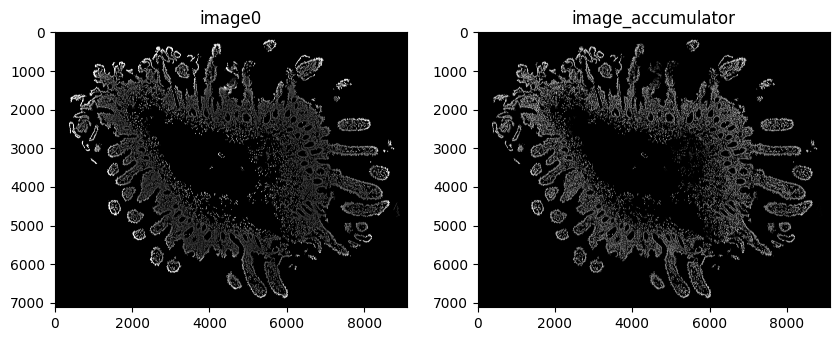

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot image0 in the first subplot
axs[0].imshow(image0, cmap='gray')
axs[0].set_title('image0')

# Plot image_accumulator in the second subplot
axs[1].imshow(image_accumulator, cmap='gray')
axs[1].set_title('image_accumulator')

# Display the plot
plt.show()

In [43]:
Image.fromarray(np.uint8(image_accumulator)).save(os.path.join(new_dir,f"AverageDAPI_{tissue_name}.tif"))

***DeepCell Inferece***

In [44]:
#https://stackoverflow.com/questions/13745648/running-bash-script-from-within-python
def run_mesmer(data_dir, nuclear_file):
    mount_dir = "/data"
    application = "mesmer"
    output_name = "mask.tif"
    compartment = "nuclear"
    image_mpp = 0.324

    docker_command = [
        "docker", "run", "--gpus", "1",
        "-v", f"{data_dir}:{mount_dir}",
        "vanvalenlab/deepcell-applications:latest-gpu",
        application,
        f"--nuclear-image={mount_dir}/{nuclear_file}",
        f"--output-directory={mount_dir}",
        f"--output-name={output_name}",
        f"--compartment={compartment}",
        f"--image-mpp={image_mpp}"
    ]

    subprocess.run(docker_command, check=True)

In [45]:
data_directory = new_dir
nuclear_file_name = f"AverageDAPI_{tissue_name}.tif"
run_mesmer(data_directory, nuclear_file_name)
print("DeepCell Inference Done")
print("Stuff seems to be working")

2024-05-24 19:48:29.463710: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 19:48:29.870776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13718 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5


[2024-05-24 19:48:35,406]:[WARNING]:[tensorflow]: No training configuration found in save file, so the model was *not* compiled. Compile it manually.
[2024-05-24 19:48:43,687]:[WARNING]:[root]: Found constant value array in batch 0 and channel 1. Normalizing as zeros.


2024-05-24 19:48:45.146884: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


[2024-05-24 19:49:25,217]:[INFO]:[Mesmer]: Wrote output file /data/mask.tif in 56.705505486926995 s.


/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/deep_watershed.py:108: UserWarning: h_maxima peak finding algorithm was selected, but the provided image is larger than 5k x 5k pixels.This will lead to slow prediction performance.
  warnings.warn('h_maxima peak finding algorithm was selected, '
/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0. Please use `footprint` instead.
  markers = h_maxima(image=maxima,


DeepCell Inference Done
Stuff seems to be working
